# <center> Interpretability Techniques for ML Models </center>
## <center> Andras Zsom </center>
<center> Assistant Professor of the Practice </center>
<center> Data Science Institute, Brown University </center>

### <center> Materials available at https://github.com/azsom/RU-interpretability-in-ML</center>


## About me
- Born and raised in Hungary
- Astrophysics PhD at MPIA, Heidelberg, Germany
- Postdoctoral researcher at MIT (still in astrophysics at the time)
- Started at Brown in 2015 as a Data Scientist in CCV (Center for Computation and Visualization)
- Lead Data Scientist since 2017 at CCV
- Assistant Professor since summer of 2021 at the DSI

# Introduction to Explainability in ML
By the end of this workshop, you will be able to
 - calculate global explanations using the coefficients of linear models
 - perform permutation importance using any ML model
 - use the SHAP package to calculate local explanations

## Motivation: simple vs. complex models
<center><img src="figures/int_vs_acc.jpg" width="700"></center>

- local feature importance improves the interpretability of complex models 
- check out [this page](http://yann.lecun.com/exdb/mnist/) for a good example

## Motivation: build trust in your model
- debugging ML models is tough
    - a model that runs without errors/warning is not necessarily correct
- model seems accurate but does it make predictions the way you expect it to be?
    - wolf vs. husky classifier
- model inspection is important
    - feature importance metrics measure how useful features are at predicting the target variable 
    - **global**: one score per feature, a vector of shape (1, n_features)
        - general overview over a larger sample size
    - **local**: one score per feature and point, an array of shape (n_samples, n_features)
        - explanation specific to each sample
- discuss the interpretability results with a subject matter expert
    - if they say something is surprising, you either
        - have a bug in your code (more likely),
        - you discovered something new which is exciting!


# <font color='LIGHTGRAY'> Introduction to Explainability in ML</font>
<font color='LIGHTGRAY'>By the end of this workshop, you will be able to</font>
 - **calculate global explanations using the coefficients of linear models**
 - <font color='LIGHTGRAY'>perform permutation importance using any ML model</font>
 - <font color='LIGHTGRAY'>use the SHAP package to calculate local explanations</font>
 


## Math recap
### Linear regression:
### <center>$f(X_i) = y_i' =w_0 + X_{i1} w_1 + X_{i2} w_2 +$ ... $= w_0 + \sum_{j=1}^{m} w_j  X_{ij} $,</center>
 
### Logistic regression:
### <center>$f(X_i) = y_i' = \frac{1}{1+e^{-z}}$,</center>
### <center>$z = w_0 + \sum_{j=1}^{m} w_j  x_{ij}$</center>

Here, $y_i'$ is the prediction of the model for sample $i$ using the $X_i$ feature vector, and $w$ are coefficients.


## What to do if you want to use the coefficients of your linear model as explanations
- **Look at the absolute value of the coefficients!**
    - a feature is important, if its coefficient's magnitude is large
    - doesn't matter if the coefficient is positive or negative
- **Standardize *ALL* features!**
    - most practitioners standarize the continuous features
    - but practicioners often forget to standarize the one-hot encoded or ordinal encoded features which is a mistake!
    - all features need to have the same mean and standard deviation if you want to use the coefficients to measure importance!
    
- **Reason**:
    - coefficient value is determined by its order of magnitude and how important it is
    - deconvolve these two effects, bring the feature means and stds to the same level

## Simple ML pipeline
- we will use the diabetes dataset in this workshop
- https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
- "Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."


In [1]:
# read in the dataset
import pandas as pd

df = pd.read_csv('data/diabetes.csv')
df.head()

y = df['Y']
X = df.loc[:, df.columns != 'Y']
print(y.head())
print(X.head())

0    151
1     75
2    141
3    206
4    135
Name: Y, dtype: int64
   AGE     SEX   BMI     BP   S1     S2    S3   S4      S5  S6
0   59    male  32.1  101.0  157   93.2  38.0  4.0  4.8598  87
1   48  female  21.6   87.0  183  103.2  70.0  3.0  3.8918  69
2   72    male  30.5   93.0  156   93.6  41.0  4.0  4.6728  85
3   24  female  25.3   84.0  198  131.4  40.0  5.0  4.8903  89
4   50  female  23.0  101.0  192  125.4  52.0  4.0  4.2905  80


In [2]:
# our ML pipeline
def MLpipe_KFold_R2(X, y, preprocessor, ML_algo, param_grid,random_state):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''

    # split data to other/test 80/20, and the use KFold with 4 folds 
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
    
    # the sklearn pipeline
    if preprocessor == None:
        # no preprocessing
        pipe = Pipeline(steps=[('regressor', ML_algo)])
    else:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', ML_algo)])
    
    # loop through the hyperparameter combinations or use GridSearchCV 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring='r2',
                        cv=kf, return_train_score=True)
    # for each combination, calculate the train and validation scores using the evaluation metric
    grid.fit(X_other, y_other)
    # find which hyperparameter combination gives the best validation score 
    print(grid.best_params_)
    
    # calculate the test score 
    test_score = grid.score(X_test,y_test)
    print(test_score)
    
    return grid.best_estimator_, test_score, (X_other, y_other), (X_test,y_test)

In [3]:
# let's try three different preprocessing techniques and collect the model coefficients!
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

param_grid = {'regressor__alpha': [1e-3,1e-2,1e-1,1e0,1e1,1e2]} 

num_ftrs = ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
ord_ftrs = ['SEX']

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])
# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#
# ordinal encode SEX only!
#
preprocessor1 = ColumnTransformer(remainder = 'passthrough',
    transformers=[
        ('ord', ordinal_transformer, ord_ftrs)])

model, test_score, train_set, test_set = MLpipe_KFold_R2(X, y, preprocessor1, Ridge(), param_grid, 42)
coefs_no_prep = model['regressor'].coef_
print(coefs_no_prep)

#
# ordinal encode SEX, and standardize continuous features
#
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('ord', ordinal_transformer, ord_ftrs)])

model, test_score, train_set, test_set = MLpipe_KFold_R2(X, y, preprocessor2, Ridge(), param_grid, 42)
coefs_some_prep = model['regressor'].coef_
print(coefs_some_prep)

#
# ordinal encode SEX, standardize continuous features, and standarize all features
#
preprocessor3 = Pipeline(steps=[
    ('prep2', preprocessor2),
    ('scaler', StandardScaler())])

model, test_score, train_set, test_set = MLpipe_KFold_R2(X, y, preprocessor3, Ridge(), param_grid, 42)
coefs_prep = model['regressor'].coef_
print(coefs_prep)


{'regressor__alpha': 1.0}
0.4520945451686045
[-22.80861461   0.14269511   5.90541998   1.19867986  -1.07900835
   0.62662466   0.3774738    9.77013169  60.79394666   0.21396887]
{'regressor__alpha': 1.0}
0.45418697357725524
[  1.79050083  25.75648091  16.71212465 -34.65085803  17.05080545
   3.3870545   11.71899321  31.39253301   2.45268588 -22.69228495]
{'regressor__alpha': 1.0}
0.454146520706982
[  1.80734179  25.73269892  16.73429974 -34.67195409  17.05307485
   3.36991411  11.76426044  31.3783838    2.45813922 -11.44818951]


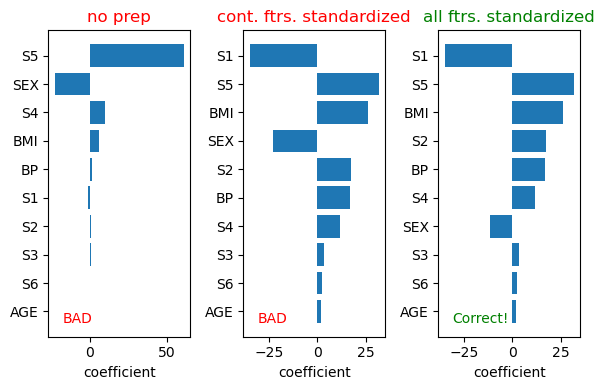

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 10})

def plot_coefs(coefs,title,color,feature_names):
    feature_names = np.array(feature_names)
    sorted_indcs = np.argsort(np.abs(coefs))
    plt.barh(np.arange(10),coefs[sorted_indcs])
    plt.yticks(np.arange(10),feature_names[sorted_indcs])
    plt.xlabel('coefficient')
    plt.title(title,color=color)
    return
    
plt.figure(figsize=(6,4))
plt.subplot(1,3,1)
plot_coefs(coefs_no_prep,'no prep','r', ord_ftrs + num_ftrs)
plt.annotate('BAD',xy=(10,10),xycoords = 'axes points',color='r')

plt.subplot(1,3,2)
plot_coefs(coefs_some_prep,'cont. ftrs. standardized','r', num_ftrs + ord_ftrs)
plt.annotate('BAD',xy=(10,10),xycoords = 'axes points',color='r')

plt.subplot(1,3,3)
plot_coefs(coefs_prep,'all ftrs. standardized','g', num_ftrs + ord_ftrs)
plt.annotate('Correct!',xy=(10,10),xycoords = 'axes points',color='g')

plt.tight_layout()
plt.savefig('figures/coefs_comparison.png',dpi=300)
plt.show()


## <font color='LIGHTGRAY'> Introduction to Explainability in ML</font>
<font color='LIGHTGRAY'>By the end of this workshop, you will be able to</font>
 - <font color='LIGHTGRAY'>calculate global explanations using the coefficients of linear models</font>
 - **perform permutation importance using any ML model**
 - <font color='LIGHTGRAY'>use the SHAP package to calculate local explanations</font>
 


## Permutation feature importance
 - model agnostic, you can use it with any supervised ML model
 - steps:
    - train a model and calculate a test score :)
    - randomly shuffle a single feature in the test set
    - recalculate the test score with the shuffled data
    - model score worsens because the shuffling breaks the relationship between feature and target
    - the larger the difference, the more important the feature is

In [5]:
from sklearn.svm import SVR
param_grid = {'regressor__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
              'regressor__gamma': [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100]}

model, test_score, train_set, test_set = MLpipe_KFold_R2(X, y, preprocessor3, SVR(), param_grid, 137)


{'regressor__C': 1000, 'regressor__gamma': 0.01}
0.5645799735371464


In [6]:
np.random.seed(42)

X_test = test_set[0]
y_test = test_set[1]
ftr_names = X_test.columns

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

print('test score = ',test_score)
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        r2_scores.append(model.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.5645799735371464
shuffling AGE
   shuffled test score: 0.537 +/- 0.02
shuffling SEX
   shuffled test score: 0.467 +/- 0.021
shuffling BMI
   shuffled test score: 0.384 +/- 0.037
shuffling BP
   shuffled test score: 0.468 +/- 0.031
shuffling S1
   shuffled test score: 0.493 +/- 0.034
shuffling S2
   shuffled test score: 0.56 +/- 0.005
shuffling S3
   shuffled test score: 0.535 +/- 0.014
shuffling S4
   shuffled test score: 0.561 +/- 0.016
shuffling S5
   shuffled test score: 0.34 +/- 0.066
shuffling S6
   shuffled test score: 0.567 +/- 0.021


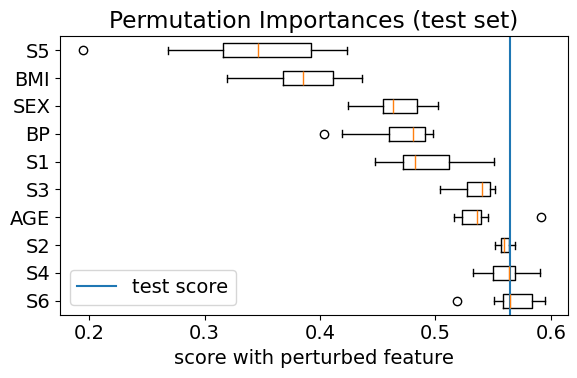

In [7]:
plt.figure(figsize=(6,4))

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## Check out sklearn's permutation importance!

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

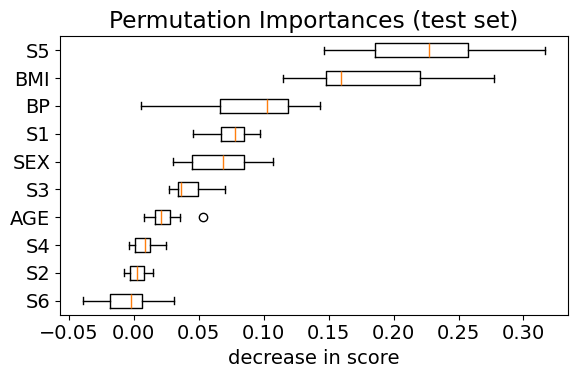

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test,n_repeats=10,random_state=42)
ftr_names = X_test.columns

sorted_indcs = result.importances_mean.argsort()

plt.figure(figsize=(6,4))

plt.rcParams.update({'font.size': 14})
plt.boxplot(result.importances[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('decrease in score')
plt.tight_layout()
plt.show()

## Cons of permutation feature importance
- strongly correlated features
   - if one of the features is shuffled, the model can still use the other correlated feature
   - both features appear to be less important but they might actually be important
   - solution:
      - check the correlation matrix plot
      - remove all but one of the strongly correlated features
- no feature interactions
   - one feature might appear unimportant but combined with another feature could be important
   - solution:
      - permute two features to measure how important feature pairs are
      - this can be computationally expensive


# <font color='LIGHTGRAY'> Introduction to Explainability in ML</font>
<font color='LIGHTGRAY'>By the end of this workshop, you will be able to</font>
 - <font color='LIGHTGRAY'>calculate global explanations using the coefficients of linear models</font>
 - <font color='LIGHTGRAY'>perform permutation importance using any ML model</font>
 - **use the SHAP package to calculate local explanations**
 


## SHAP values
- one way to calculate local feature importances
- it is based on Shapely values from game theory
- read more [here](https://arxiv.org/abs/1802.03888), [here](https://github.com/slundberg/shap), and [here](https://christophm.github.io/interpretable-ml-book/shap.html)

### Cooperative game theory
- A set of *m* players in a coalition generate a surplus.
- Some players contribute more to the coalition than others (different bargaining powers).
- How important is each player to the coalition?
- How should the surplus be divided fairly amongst the players?

### Cooperative game theory <font color='red'>applied to feature attribution</font>
- A set of *m* <font color='red'>features</font> in a <font color='red'>model</font> generate a <font color='red'>prediction</font>.
- Some <font color='red'>features</font> contribute more to the <font color='red'>model</font> than others (different <font color='red'>predictive</font> powers).
- How important is each <font color='red'>feature</font> to the <font color='red'>model</font>?
- How should the <font color='red'>prediction</font> be divided amongst the <font color='red'>features</font>?

## How is it calculated?
### $\Phi_i = \sum_{S\subseteq M\setminus i}  \frac{|S|!(M - |S| - 1)!} {M!} [f_x(S\cup i) - f_x(S)]$

- $\Phi_i$ - the contribution of feature $i$
- $M$ - the number of features
- $S$ - a set of features excluding $i$, a vector of 0s and 1s (0 if a feature is not used)
- $|S|$ - the number of features in $S$
- $f_x(S)$ - the prediction of the model with features $S$

## How is it calculated?
### $\Phi_i = \sum_{S\subseteq M\setminus i} \color{blue}{\frac{|S|!(M - |S| - 1)!} {M!}}\color{red}{[f_x(S\cup i) - f_x(S)]}$
- <font color='red'>the difference feature $i$ makes in the prediction: </font>
    - <font color='red'>$f_x(S\cup i)$ - the prediction with feature $i$</font>
    - <font color='red'>$f_x(S)$ - the prediction without feature $i$</font>
- loop through all possible ways a set of S features can be selected from the M features excluding i
- <font color='blue'>weight the contribution based on how many ways we can select $|S|$ features</font>

## An example

- Let's calculate the weight term (in blue) of the shap equation. 
- Let's assume we have 4 features and we want to calculate the shap value of one of them. 
- Then M = 4, S can be [0,0,0], [1,0,0], [0,1,0],[0,0,1], [1,1,0], [1,0,1], [0,1,1], and [1,1,1].
- |S| is 0, 1, 1, 1, 2, 2, 2, 3, respectively. 
- The blue term is $\frac{|S|!(M-|S|-1)!}{M!}$ and it can have four values:
    - if |S| = 0, then 0!*(4-1)!/4! = 1/4.
    - if |S| = 1, then 1!*(4-1-1)!/4! = 2!/4! = 1/12.
    - if |S| = 2, then 2!*(4-2-1)!/4! = 1/12.
    - if |S| = 3, then 3!*(4-3-1)!/4! = 1/4.

- Note that |S| = 0 and 3 only once, while |S| = 1 and 2 three times. 
    - 1* 1/4 + 3* 1/12 + 3* 1/12 + 1* 1/4 = 1 so the sum of the weights is 1.


In [9]:
import shap
shap.initjs() # required for visualizations later on

explainer = shap.KernelExplainer(model[1].predict,model[0].transform(train_set[0]))
# transform the test set
X_test_transformed = model[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the test
shap_values = explainer.shap_values(X_test_transformed)
print(np.shape(shap_values))
ftr_names = num_ftrs + ord_ftrs

Using 353 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


(89, 10)


  0%|          | 0/89 [00:00<?, ?it/s]

(89, 10)


## Explain a point

In [10]:
ftr_names = np.array(num_ftrs + ord_ftrs)

index = 3 # the index of the point to explain

shap.force_plot(explainer.expected_value, shap_values[index,:], X_test_transformed[index,:],feature_names=ftr_names)



## Feature value vs. shap value

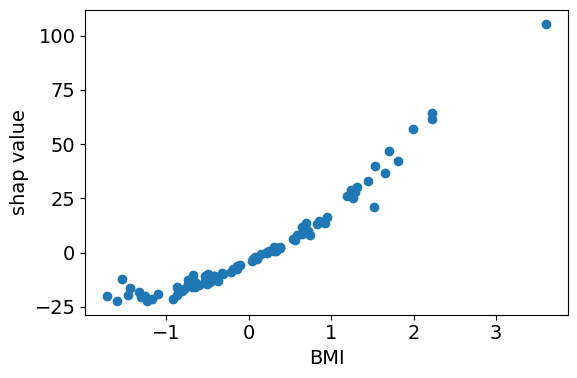

In [11]:
ftr = 'BMI'
indx = np.argwhere(ftr_names==ftr)

plt.figure(figsize=(6,4))

plt.scatter(X_test_transformed[:,indx],shap_values[:,indx])
plt.ylabel('shap value')
plt.xlabel(ftr)
plt.tight_layout()
plt.show()


## Dependence plot

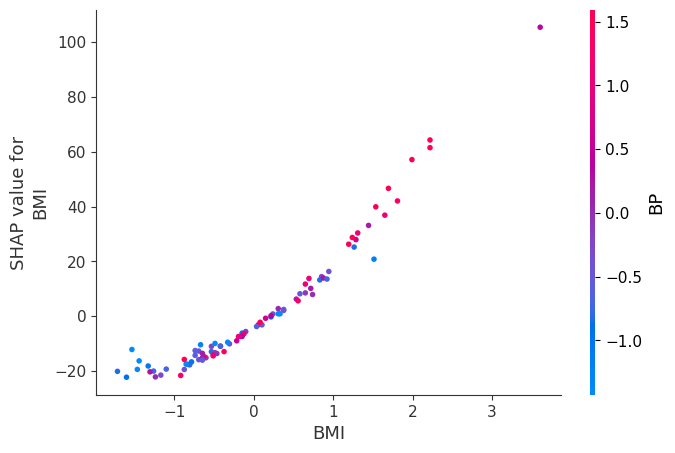

In [12]:
shap.dependence_plot('BMI', shap_values, X_test_transformed, feature_names=ftr_names,interaction_index="BP")


## It can also be used for global feature importance

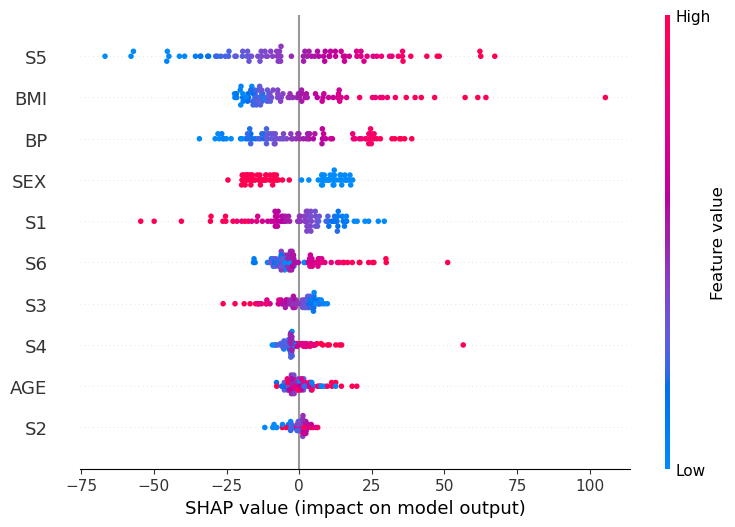

In [13]:
shap.summary_plot(shap_values, X_test_transformed,feature_names = ftr_names,rng=42)

## SHAP cons
- it can be numerically expensive
   - an efficient shap method was developed for trees, see [here](https://arxiv.org/abs/1905.04610)
- how to estimate $f_x(S)$?
   - this is not trivial because models cannot change the number of features they use
   - usually the values of the dropped features are replaced with the mean or 0
   - this is an approximation 


# Recap: Introduction to Explainability in ML
By now, you can
 - calculate global explanations using the coefficients of linear models
 - perform permutation importance using any ML model
 - use the SHAP package to calculate local explanations
 
